In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.utils as Utils
from sklearn.metrics import confusion_matrix
#import mplhep as hep

In [39]:
class GraphNet(nn.Module):
    def __init__(self, input_dim = 8, hidden_dim = 64, output_dim = 1, aggr = 'add', niters = 3):
        super(GraphNet, self).__init__()
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data):
        X = data.x
        #print(f"edges {data.num_edges}")
        #print(f"initial X size {X.size()}")
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            (prepared_edges, _) = Utils.add_self_loops(data.edge_index)
            H = self.graphconv(H, Utils.to_undirected(prepared_edges))
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [3]:
# Load data
f = "dataset_closeByDoublePion/"
with open(f+"node_features", "rb") as fp:
    X = pickle.load(fp)
    
with open(f+"edges", "rb") as fp:
    Edges = pickle.load(fp)
    
with open(f+"edges_labels", "rb") as fp:
    Edge_labels = pickle.load(fp)

In [4]:
# process data
edge_data = []
edge_label = []
node_data = []
for ev in range(len(X)):
    if len(Edges[ev]) == 0:
        print(f"event {ev} edges {Edges[ev]}")
        continue # skip events with no edges
    else:
        X_ev = []
        edge_data.append(Edges[ev])
        edge_label.append([np.float32(edg) for edg in Edge_labels[ev]])
        for field in X[ev].fields:
            X_ev.append(ak.to_numpy(X[ev][field]))
        node_data.append(X_ev)

event 151 edges []
event 7097 edges []
event 7409 edges []
event 7966 edges []
event 10130 edges []
event 10375 edges []
event 15526 edges []
event 19978 edges []


In [16]:
data_list = []
process_events = 10000 # len(node_data)
for ev in range(process_events):
    x = torch.from_numpy(np.array(node_data[ev]).T)
    e_label = torch.from_numpy(np.array(edge_label[ev]))
    edge_index = torch.from_numpy(edge_data[ev])
    data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=e_label)
    data_list.append(data)

In [17]:
# split into train, val, test sets

trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1

nSamples = len(data_list)

nTrain = int( trainRatio * nSamples  )
nVal = int( valRatio * nSamples )

trainDataset = data_list[:nTrain]           # training dataset
valDataset = data_list[nTrain:nTrain+nVal]  # validation dataset
testDataset = data_list[nTrain+nVal:]       # test dataset

In [18]:
len(trainDataset)

8000

In [47]:
# Imbalance in training
train_edges_total = 0
train_edges_true = 0
train_edges_false = 0

for tr_data in trainDataset:
    train_edges_total += len(tr_data.edge_index[0])
    for label in tr_data.edge_label:
        if label.numpy() == 0:
            train_edges_false += 1
        elif label.numpy() == 1:
            train_edges_true += 1
        
print(f"Total edges in training : {train_edges_total}")
print(f"True edges : {train_edges_true}")
print(f"False edges : {train_edges_false}")

# edges in test dataset
test_edges_total = 0
for test_data in testDataset:
    test_edges_total += len(test_data.edge_index[0])

Total edges in training : 2290752
True edges : 1789204
False edges : 501548


In [20]:
# Calculate weights
w_false = train_edges_total/(2*train_edges_false)
w_true = train_edges_total/(2*train_edges_true)
print(f"Weights True, False edges : {w_true}, {w_false}")

Weights True, False edges : 0.6401595346310426, 2.283681721390575


In [41]:
def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

In [42]:
# Training

epochs = 10
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNet().to(device)
#data = data_list.to(device)
trainLoader = DataLoader(trainDataset, batch_size=batch_size)
valLoader = DataLoader(valDataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_loss_history = []
val_loss_history = []
model.train()
for epoch in range(epochs):
    batchloss = []
    for sample in trainLoader:
        optimizer.zero_grad()
        sample.to(device)
        out = model(sample)
        weight = [w_true if l > 0.9 else w_false for l in sample.edge_label] # weigh edges
        loss = F.binary_cross_entropy(out, sample.edge_label, weight=torch.tensor(weight))
        bce_loss = F.binary_cross_entropy(out, sample.edge_label)
        loss = focal_loss(bce_loss, sample.edge_label, 2, 0.4)
#         print(f"out {out}")
#         print(f"label {sample.edge_label}")
#         print(f"loss {loss}")
        batchloss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    train_loss_history.append(np.mean(batchloss))

    with torch.set_grad_enabled( False ):
        batchloss = []
        for sample in valLoader:
            out = model(sample)
            val_loss = F.binary_cross_entropy_with_logits(out, sample.edge_label)
            val_bce = F.binary_cross_entropy(out, sample.edge_label)
            val_loss = focal_loss(val_bce, sample.edge_label, 2, 0.4)
            batchloss.append(val_loss.item())
            
    val_loss_history.append(np.mean(batchloss))
    print(f"epoch {epoch} - train loss {train_loss_history[-1]:.4f} - val loss {val_loss_history[-1]:.4f}")

epoch 0 - train loss 0.05 - val loss 0.03
epoch 1 - train loss 0.03 - val loss 0.03
epoch 2 - train loss 0.03 - val loss 0.03
epoch 3 - train loss 0.03 - val loss 0.03
epoch 4 - train loss 0.03 - val loss 0.03
epoch 5 - train loss 0.03 - val loss 0.03
epoch 6 - train loss 0.03 - val loss 0.03
epoch 7 - train loss 0.03 - val loss 0.03
epoch 8 - train loss 0.03 - val loss 0.03
epoch 9 - train loss 0.03 - val loss 0.03


In [ ]:
for params in model.parameters():
    print(params)

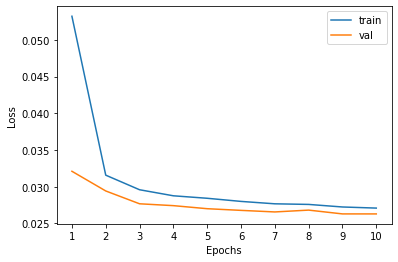

In [43]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xticks(range(epochs), range(1, epochs+1))
plt.legend()

In [ ]:
# Save model so as not to repeat the training
PATH = "model/trackster_graphconv"
torch.save(model.state_dict(), PATH)

In [ ]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = GraphNet()
model_test.load_state_dict(torch.load(PATH))
model_test.eval()
model_test.to(device)

In [44]:
classification_threshold = 0.7
def getAccuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > classification_threshold
    return (y_true == y_prob).sum().item() / y_true.size(0)

testLoader = DataLoader(testDataset, batch_size=32)
print("loaded")

predictions = []
truth = []
accuracies = []

for sample in testLoader:
    sample.to(device)
    out = model(sample)
    #print(f"out {out}")
    acc = getAccuracy(sample.edge_label, out)
    accuracies.append(acc)
    #print(f"out {acc}")
    y_test = out > classification_threshold
    predictions.append(y_test.numpy())
    truth.append(sample.edge_label.numpy())
    
cf_matrix = confusion_matrix(np.concatenate(truth), np.concatenate(predictions))
#cf_matrix = confusion_matrix(sample.edge_label.detach().numpy(), y_test.detach().numpy())
print(f"Accuracy in test data {np.mean(accuracies)*100:.2f} %")
print(f"Confusion matrix {cf_matrix}")

loaded
Accuracy in test data 71.54 %
Confusion matrix [[ 41713  21545]
 [ 60495 164829]]


In [48]:
# normalized to total edges in test dataset
cf_matrix/test_edges_total

array([[0.1445447 , 0.07465816],
       [0.20962846, 0.57116868]])

TN: 41713, FP: 21545, FN: 60495, TP: 164829


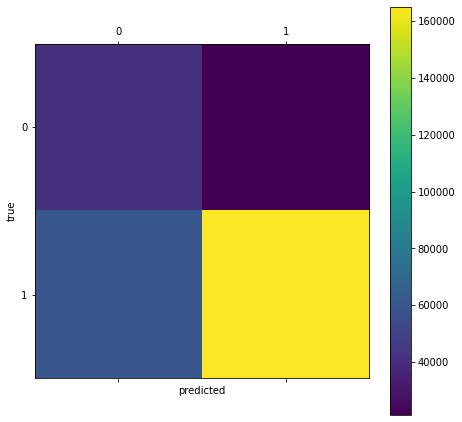

In [49]:
tn, fp, fn, tp = cf_matrix.ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.set_xlabel("predicted")
px.set_ylabel("true")
cax = px.matshow(cf_matrix)
fig.colorbar(cax)